## 요약
- mecab을 이용한 기본 설정 tokenize
    - 이후 품사를 제한해보는 것도 필요
- padding & integer encoding
    - BName, BName_sub, Category에 적용
    - maxlen은 각각 30,25,5로 ths를 정함

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

# 그래프의 폰트 출력을 선명하게 (svg, retina 등이 있음)
matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
# 테마 설정: "default", "classic", "dark_background", "fivethirtyeight", "seaborn"
mpl.style.use("default")
# 이미지가 레이아웃 안으로 들어오도록 함
# https://matplotlib.org/stable/users/explain/axes/constrainedlayout_guide.html
mpl.rcParams.update({"figure.constrained_layout.use": True})

#font, line, marker 등의 배율 설정: paper, notebook, talk, poster
sns.set_context("paper") 
#배색 설정: tab10, Set2, Accent, husl
sns.set_palette("Set2") 
#눈금, 배경, 격자 설정: ticks, white, whitegrid, dark, darkgrid
# withegrid: 눈금을 그리고, 각 축의 눈금을 제거
sns.set_style("whitegrid") 

In [2]:
# 로컬에서 

plt.rc("font", family = "D2Coding")
plt.rcParams["axes.unicode_minus"] = False

In [3]:
import os, natsort, re
from tqdm import tqdm
import time, random

In [4]:
PRJCT_PATH = '/home/doeun/code/AI/ESTSOFT2024/workspace/2.project_text/aladin_usedbook/'
save_dir = 'processed/'
file_name = f'bookinfo_ver0.75.csv'

In [18]:
file_path = os.path.join(PRJCT_PATH,save_dir,file_name)
bookinfo = pd.read_csv(file_path)
bookinfo

,Rank,BName,BName_sub,ItemId,Author,Author_mul,Publshr,Pdate,RglPrice,SlsPrice,SalesPoint,Category,Sorce
0,322.0,민병철 생활영어 1,NaN,54947,민병철,False,기타 출판사,1979-10-01,5500,4950,177.0,외국어,2001년1월3주
1,767.0,행복에의 초대,NaN,168173,IVP(한국기독학생회출판부) 편집부,False,기타 출판사,1979-12-01,2800,2660,1960.0,종교/역학,2005년2월1주
2,449.0,훈련으로 되는 제자,NaN,458277,월터 A. 헨릭슨,False,기타 출판사,1980-12-01,4500,4050,552.0,종교/역학,2005년2월1주
3,490.0,전태일 평전,NaN,128759,조영래,False,돌베개,1983-06-01,6000,6000,409.0,사회과학,2001년1월3주
4,300.0,제자의 삶,NaN,131488,프랜시스 M.코스그로브,False,기타 출판사,1984-07-01,12000,12000,1110.0,종교/역학,2005년2월1주
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9323,68.0,장송의 프리렌 12,NaN,342597187,야마다 카네히토,True,학산문화사(만화),2024-07-25,6000,5400,10530.0,만화,2024년7월2주
9324,138.0,약사의 혼잣말 13,NaN,342597589,네코쿠라게,True,학산문화사(만화),2024-07-25,6000,5400,5870.0,만화,2024년7월2주
9325,129.0,타몬 군 지금 어느 쪽?! 7,NaN,342597714,시와스 유키,True,학산문화사(만화),2024-07-25,6000,5400,6370.0,만화,2024년7월2주
9326,209.0,천재 의사 시건방 1,NaN,342388828,강효미,True,기타 출판사,2024-07-31,13000,11700,8190.0,어린이,2024년7월2주


In [19]:
cond = bookinfo.Author == '박지원 외'
np.sum(cond)

0

In [20]:
bookinfo[cond]

,Rank,BName,BName_sub,ItemId,Author,Author_mul,Publshr,Pdate,RglPrice,SlsPrice,SalesPoint,Category,Sorce


#### 크롤링으로 저자 정보를 가져오게 되면 안 생길 문제지만, 일단 추가 전처리 진행
000 외 


In [21]:
book_author = bookinfo.Author
temp = book_author.str.split(' ')
display(temp)


0                        [민병철]
1       [IVP(한국기독학생회출판부), 편집부]
2                [월터, A., 헨릭슨]
3                        [조영래]
4              [프랜시스, M.코스그로브]
                 ...          
9323               [야마다, 카네히토]
9324                   [네코쿠라게]
9325                 [시와스, 유키]
9326                     [강효미]
9327                     [송영관]
Name: Author, Length: 9328, dtype: object

In [22]:
np.sum(temp.isna())

0

##### 기타 : 장 자끄 상뻬 글
- 815.0,국내도서,얼굴 빨개지는 아이,194628,9788932902456,3860.0,"장 자끄 상뻬 글 그림, 김호영 옮김",열린책들,1999-05-30,8500,7650,420점,5262.0,에세이,2005년2월1주
- 현재 사이트에는 지은이로 되어있음

In [26]:
cond = bookinfo.Author == '장 자끄 상뻬'
bookinfo[cond]

,Rank,BName,BName_sub,ItemId,Author,Author_mul,Publshr,Pdate,RglPrice,SlsPrice,SalesPoint,Category,Sorce
284,815.0,얼굴 빨개지는 아이,NaN,194628,장 자끄 상뻬,True,열린책들,1999-05-30,8500,7650,5262.0,에세이,2005년2월1주


In [27]:
bookinfo.loc[59]

Rank               887.0
BName             오행은 뭘까
BName_sub            NaN
ItemId            107339
Author           전창선.어윤형
Author_mul         False
Publshr           기타 출판사
Pdate         1994-06-01
RglPrice            7500
SlsPrice            6750
SalesPoint         991.0
Category             인문학
Sorce          2001년1월3주
Name: 59, dtype: object

In [28]:
from konlpy.tag import Mecab
mecab = Mecab()
tokenizer_basic = lambda x : mecab.morphs(x)

# 출처: https://sikaleo.tistory.com/62 [SIKALEO:티스토리]
def tokenizer_kor(raw, pos=["NNG","NNP","VV","VA"]):
    from konlpy.tag import Mecab
    m = Mecab()
    # 길이가 1 이하인 토근은 제외, 위에서 지정한 (mecab 사전에 따른) 토큰들만 특징으로 삼기, 불용어 100개 제외  
    return [word for word, tag in m.pos(raw) if tag in pos]

In [29]:
book_name,book_subname, category = bookinfo.BName, bookinfo.BName_sub, bookinfo.Category
book_name = book_name.apply(tokenizer_basic)
book_subname = book_subname.fillna('').apply(tokenizer_basic)
category = category.apply(tokenizer_basic)

### Integer encoding
- 빈도순으로 정렬하여 가장 많이 나온 token을 1로 시작해서, 양의 정수로 인코딩 
- 길이 통일을 위한 ```'[PAD]'```는 0으로 encoding

In [30]:
import itertools
tokens = np.array(list(itertools.chain(*book_name.values,*book_subname.values,*category.values)))
len(tokens)

84183

In [31]:
corpus = np.unique(tokens,return_counts=True)
display(corpus)
display(len(corpus[0]))

(array(['!', '$', '%', ..., '老子', '漏泄', '六'], dtype='<U14'),
 array([190,   1,  15, ...,   1,   1,   1]))

8541

In [32]:
df_corpus = pd.DataFrame(corpus).T
df_corpus = df_corpus.rename(columns={0:'token',1:'counts'})
df_corpus

,token,counts
0,!,190
1,$,1
2,%,15
3,&,48
4,',24
...,...,...
8536,힙합,2
8537,洛陽,1
8538,老子,1
8539,漏泄,1


- 보통 단어 개수를 32000개쯤 한다는 것 같은데(부정확) 9000개 정도면 크지 않은 것 같음

In [33]:
cond = df_corpus.counts < 2
df_corpus[cond]

,token,counts
1,$,1
16,001,1
18,014,1
20,07,1
21,08,1
...,...,...
8535,힙,1
8537,洛陽,1
8538,老子,1
8539,漏泄,1


In [34]:
targets = [
"／"]
detect_target = lambda x : len(set(x).intersection(set(targets))) > 0
cond = book_name.apply(detect_target)
bookinfo[cond]

,Rank,BName,BName_sub,ItemId,Author,Author_mul,Publshr,Pdate,RglPrice,SlsPrice,SalesPoint,Category,Sorce


In [35]:
temp = df_corpus.sort_values(by='counts',ascending=False)
temp['val'] = np.arange(len(temp))+1
temp = temp.set_index('token')
temp

,counts,val
token,,
/,5608,1
의,2135,2
시,1857,3
소설,1769,4
희곡,1735,5
...,...,...
사이키,1,8537
사이언스,1,8538
사이보그,1,8539


In [36]:
temp2 = temp.to_dict()
map_token_encode = temp2['val']
map_token_encode['[PAD]']=0
map_token_encode

{'/': 1,
 '의': 2,
 '시': 3,
 '소설': 4,
 '희곡': 5,
 '는': 6,
 '만화': 7,
 '(': 8,
 ')': 9,
 '수험서': 10,
 '자격증': 11,
 '1': 12,
 '은': 13,
 '2': 14,
 '인문학': 15,
 '경제': 16,
 '경영': 17,
 '에세이': 18,
 '하': 19,
 '외국어': 20,
 '한': 21,
 '과학': 22,
 '이': 23,
 '자기': 24,
 '을': 25,
 '계발': 26,
 '-': 27,
 ',': 28,
 '3': 29,
 '+': 30,
 '다': 31,
 '사회': 32,
 '권': 33,
 '를': 34,
 '좋': 35,
 '나': 36,
 '가': 37,
 '컴퓨터': 38,
 '기': 39,
 '에': 40,
 '부모': 41,
 '전': 42,
 '종교': 43,
 '역학': 44,
 '.': 45,
 ':': 46,
 '모바일': 47,
 '해': 48,
 '역사': 49,
 '들': 50,
 '청소년': 51,
 '지': 52,
 '고': 53,
 '급': 54,
 '예술': 55,
 '4': 56,
 '건강': 57,
 '문화': 58,
 '대중': 59,
 '커스': 60,
 '영어': 61,
 '기출': 62,
 '과': 63,
 '취미': 64,
 '요리': 65,
 '2016': 66,
 '!': 67,
 '문제집': 68,
 '살림': 69,
 '와': 70,
 '로': 71,
 '능력': 72,
 '5': 73,
 '있': 74,
 '2019': 75,
 '제': 76,
 '토익': 77,
 '일': 78,
 '으로': 79,
 '7': 80,
 '내': 81,
 '읽': 82,
 '세트': 83,
 '실전': 84,
 '게': 85,
 '아이': 86,
 '도': 87,
 '않': 88,
 '말': 89,
 '이야기': 90,
 '만': 91,
 '시험': 92,
 '10': 93,
 '어': 94,
 '편': 95,
 '

### padding & integer encoding

In [37]:
display(book_name.shape)
display(book_name[0])
len_sent = list(map(len,book_name))
display(max(len_sent),min(len_sent))

(9328,)

['민병철', '생활', '영어', '1']

32

1

In [38]:
display(len_sent[np.argmax(len_sent)])
print(book_name[np.argmax(len_sent)])

32

['2022', '최신', '판', '렛', '유인', '공기업', '시험', '전', ',', '실전', '감각', 'UP', '!', '단', '5', '+', '3', '회', '로', '취약점', '정면', '돌파', '!', '국민', '건강보험공단', 'NCS', '봉투', '모의고사', '5', '+', '3', '회']


In [39]:
np.sum(np.array(len_sent) >= 30)

1

<Axes: ylabel='Count'>

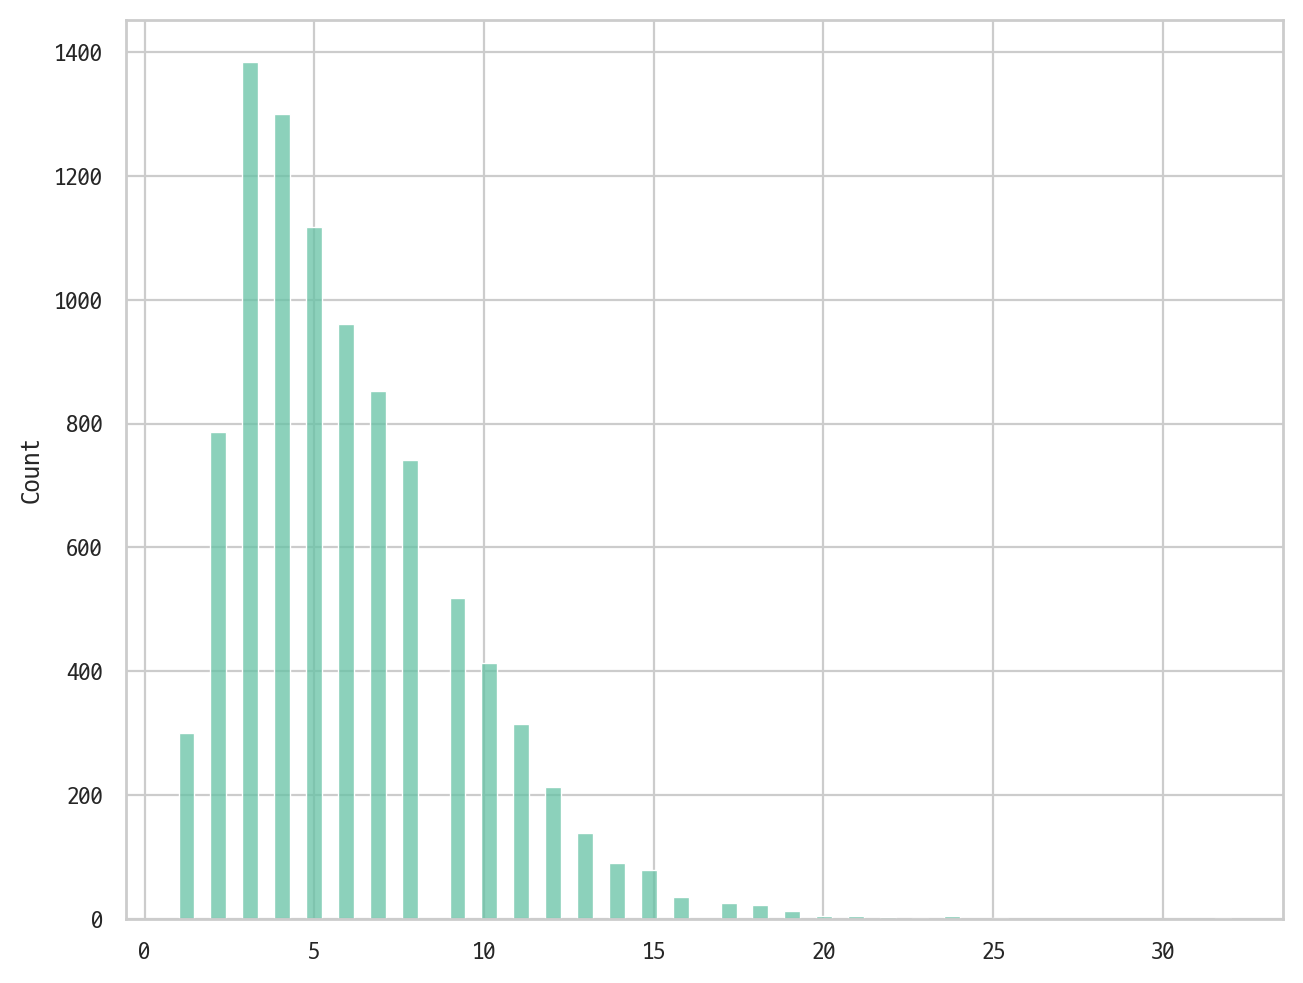

In [40]:
sns.histplot(len_sent)

In [41]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded_bookname = pad_sequences(book_name,padding='post',maxlen=30,value='[PAD]',dtype=object)
display(padded_bookname.shape)
padded_bookname

2024-07-17 02:26:39.656185: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-17 02:26:40.096729: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-17 02:26:40.129677: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-07-17 02:26:40.129702: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not ha

(9328, 30)

array([['민병철', '생활', '영어', ..., '[PAD]', '[PAD]', '[PAD]'],
       ['행복', '에', '의', ..., '[PAD]', '[PAD]', '[PAD]'],
       ['훈련', '으로', '되', ..., '[PAD]', '[PAD]', '[PAD]'],
       ...,
       ['타', '몬', '군', ..., '[PAD]', '[PAD]', '[PAD]'],
       ['천재', '의', '사', ..., '[PAD]', '[PAD]', '[PAD]'],
       ['전지', '적', '루이', ..., '[PAD]', '[PAD]', '[PAD]']], dtype=object)

In [42]:
encode_tokens = lambda x: list(map(lambda y : map_token_encode[y],x))
encoded_bookname = np.apply_along_axis(encode_tokens,0,padded_bookname)
encoded_bookname

array([[8075,  353,   61, ...,    0,    0,    0],
       [ 219,   40,    2, ...,    0,    0,    0],
       [ 925,   79,  124, ...,    0,    0,    0],
       ...,
       [1147, 2270,  406, ...,    0,    0,    0],
       [ 496,    2,  148, ...,    0,    0,    0],
       [1193,  102, 5880, ...,    0,    0,    0]])

In [43]:
len_sent = list(map(len,book_subname))
max(len_sent),min(len_sent)

(44, 0)

<Axes: ylabel='Count'>

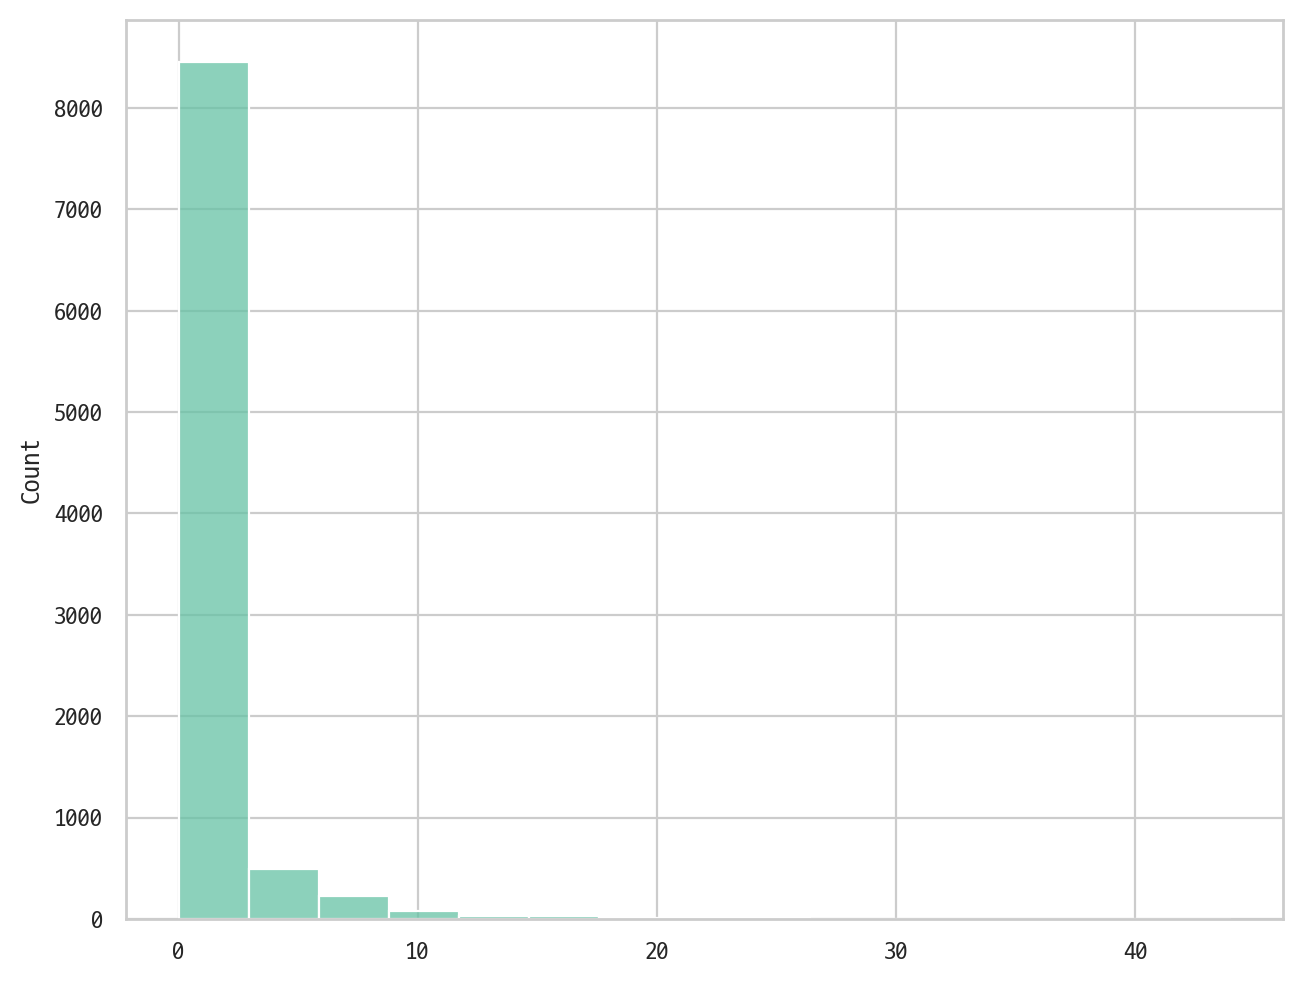

In [44]:
sns.histplot(len_sent)

In [45]:
display(len_sent[np.argmax(len_sent)])
print(book_subname[np.argmax(len_sent)])

44

['(', '캐릭터', '책갈피', '1', '종', '+', '투명', '포토', '카드', '2', '종', '+', 'DIY', '편지지', '책자', '+', '컵', '홀더', '2', '종', '+', '테이블', '매트', '(', '패브릭', '포스터', ')', '+', '종이', '코스터', '2', '종', '+', '주접', '대사', '스티커', '3', '종', '+', '박스', '포함', '한', '정판', ')']


In [46]:
display(np.sum(np.array(len_sent) >= 20))
display(np.sum(np.array(len_sent) >= 25))
display(np.sum(np.array(len_sent) >= 30))

21

5

3

In [47]:
cond = (np.array(len_sent) > 25)
book_subname[cond]

2836    [(, 테이프, 별매, ), (, Hackers, TOEIC, Listening, ...
3226    [(, 교재, (, ETS, X, -, File, 빈출, 표현, 수록, ), +, ...
4815    [(, 국가, 직무, 능력, 표준, ), 직업, 기초, 능력, 평가, +, 직무, ...
5895    [(, 본, 책, +, 예문, 듣, 기, MP, 3, 파일, 무료, 다운, 로드, ...
8513    [(, 캐릭터, 책갈피, 1, 종, +, 투명, 포토, 카드, 2, 종, +, DI...
Name: BName_sub, dtype: object

In [48]:
padded_subname = pad_sequences(book_subname,padding='post',maxlen=25,value='[PAD]',dtype=object)
encoded_subname = np.apply_along_axis(encode_tokens,0,padded_subname)
encoded_subname

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       ...,
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  8, 957,   9, ...,   0,   0,   0]])

In [49]:
len_sent = list(map(len,category))
max(len_sent),min(len_sent)

(5, 1)

In [50]:
display(len_sent[np.argmax(len_sent)])
display(category[np.argmax(len_sent)])

5

['소설', '/', '시', '/', '희곡']

<Axes: ylabel='Count'>

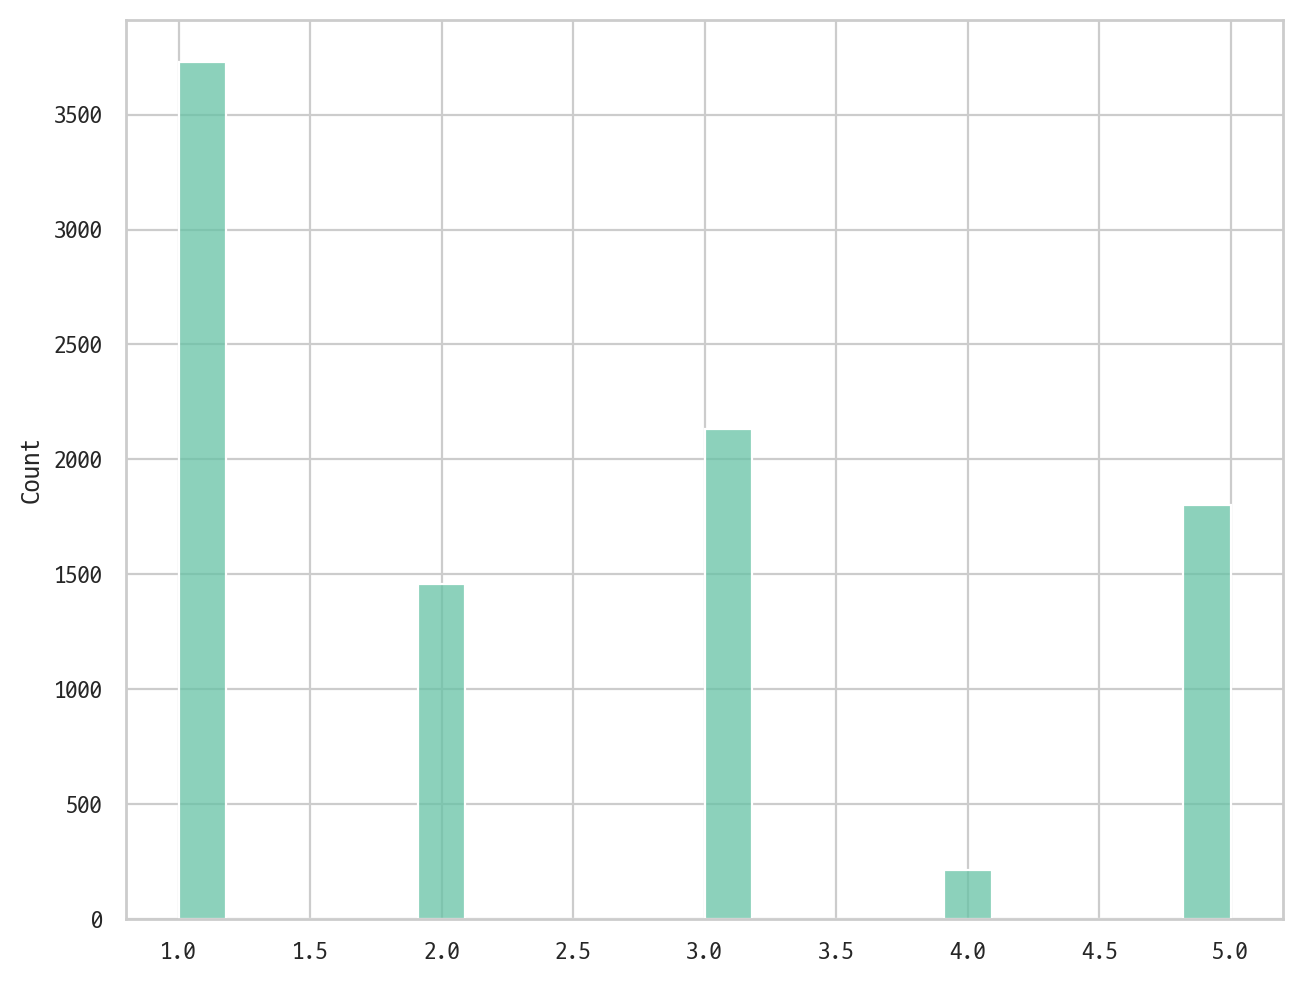

In [51]:
sns.histplot(len_sent)

In [52]:
padded_category = pad_sequences(category,padding='post',maxlen=5,value='[PAD]',dtype=object)
encoded_category = np.apply_along_axis(encode_tokens,0,padded_category)
encoded_category

array([[ 20,   0,   0,   0,   0],
       [ 43,   1,  44,   0,   0],
       [ 43,   1,  44,   0,   0],
       ...,
       [  7,   0,   0,   0,   0],
       [133,   0,   0,   0,   0],
       [ 18,   0,   0,   0,   0]])

#### publshr, author encoding
- publshr는 k = 50 기준으로 전처리 했었음
- author에 대해서도 파악 필요

In [53]:
authors = bookinfo.Author
counts = authors.value_counts()
counts

Author
데이빗 조 (David Cho)    49
길벗 R&D               43
이동기                  37
ETS                  37
해커스어학연구소             36
                     ..
초(정솔)                 1
구수환                   1
남충희                   1
요시다 타로                1
시와스 유키                1
Name: count, Length: 5549, dtype: int64

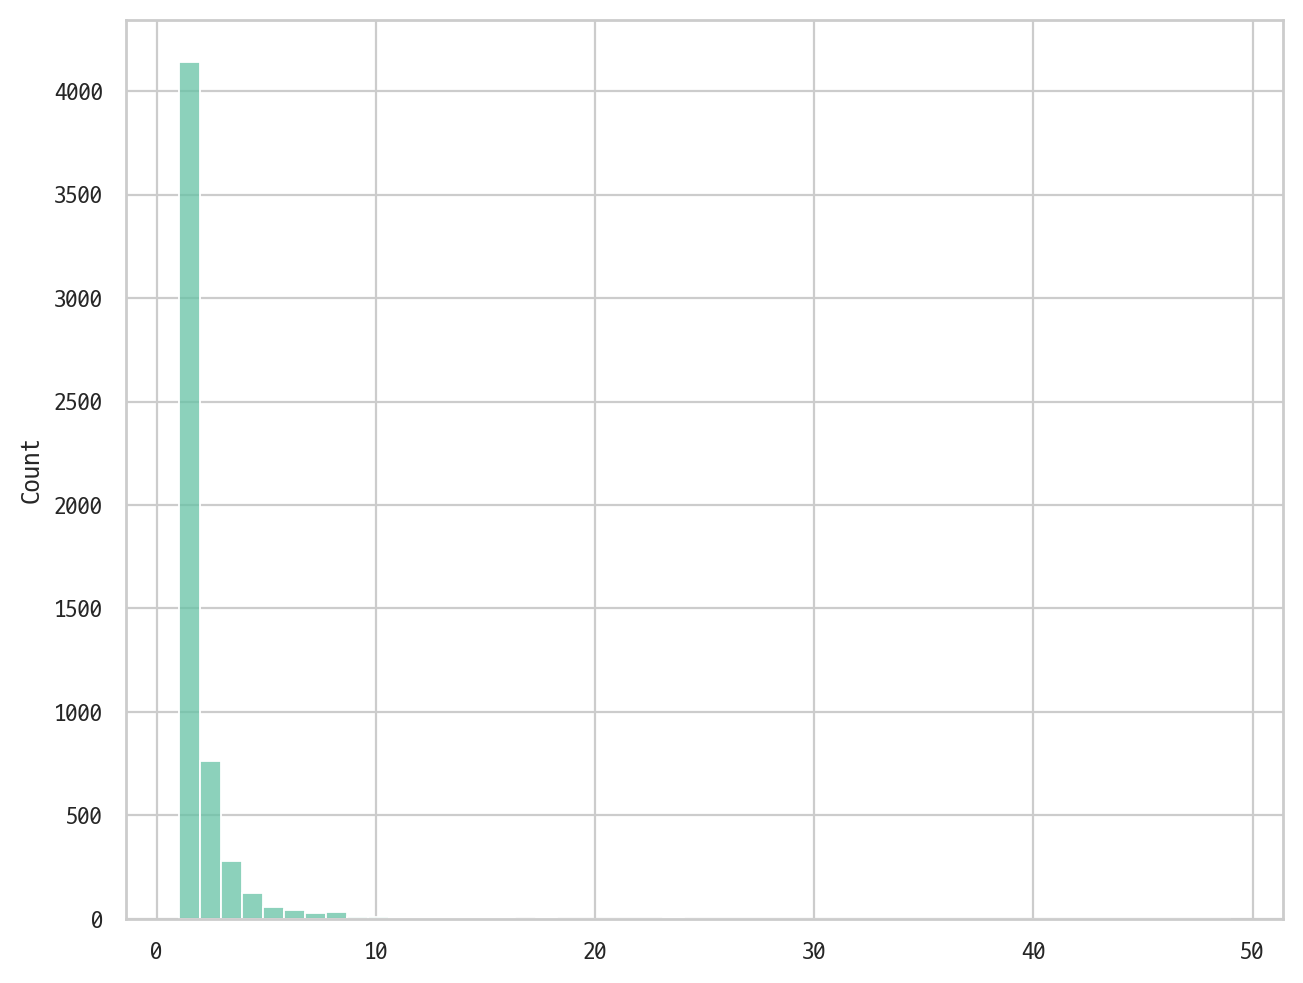

In [54]:
sns.histplot(counts.values,bins=50);

In [55]:
cond = counts >= 2
counts[cond]

Author
데이빗 조 (David Cho)    49
길벗 R&D               43
이동기                  37
ETS                  37
해커스어학연구소             36
                     ..
강명재                   2
이랑                    2
폴 리쾨르                 2
미카와 고스트               2
윤우상                   2
Name: count, Length: 1411, dtype: int64

In [56]:
cond = counts == 2
counts[cond]

Author
이철수          2
열린책들 편집부     2
최인원          2
랄프 왈도 에머슨    2
유연           2
            ..
강명재          2
이랑           2
폴 리쾨르        2
미카와 고스트      2
윤우상          2
Name: count, Length: 764, dtype: int64

**만약 SalesPoint를 반영한다면?**

In [57]:
pvtb = pd.pivot_table(data=bookinfo,index='Author',values='SalesPoint',aggfunc=np.sum)
pvtb = pvtb.sort_values(by='SalesPoint',ascending=False)
pvtb

,SalesPoint
Author,
ETS,1138125.0
David Cho,870206.0
데이빗 조 (David Cho),819133.0
유시민,743504.0
최태성,613568.0
...,...
윤재근,21.0
정영택,20.0
생명의삶,17.0


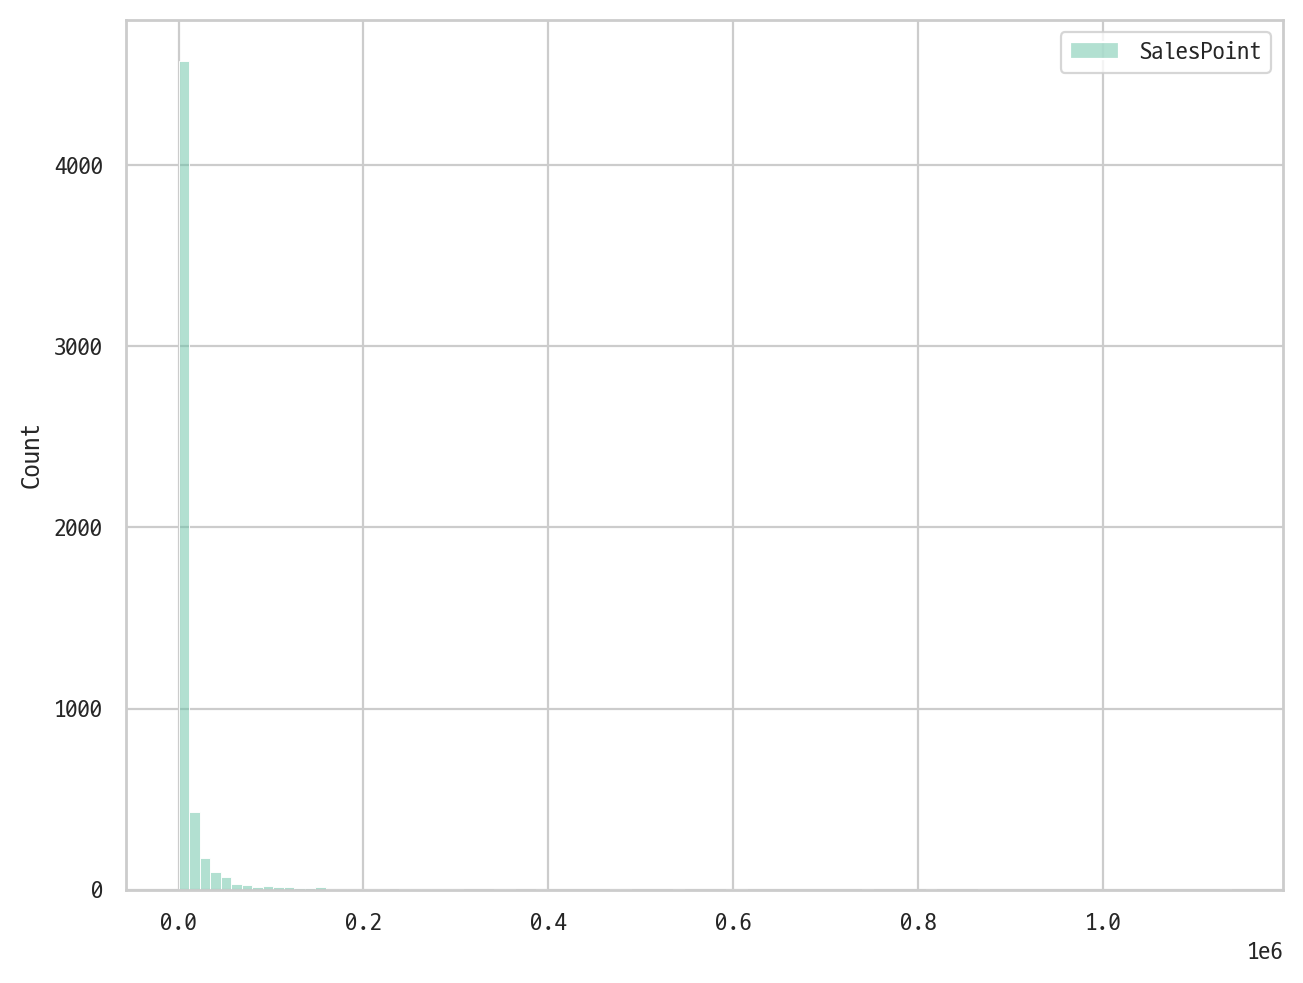

In [58]:
sns.histplot(pvtb,bins=100);

In [59]:
cond = pvtb['SalesPoint'] >= 10000
pvtb[cond]

,SalesPoint
Author,
ETS,1138125.0
David Cho,870206.0
데이빗 조 (David Cho),819133.0
유시민,743504.0
최태성,613568.0
...,...
NCS 정보처리기술사 연구회,10105.0
러셀 로버츠,10102.0
김도윤,10061.0


In [60]:
cond = pvtb['SalesPoint'] >= 5000 
pvtb[cond]

,SalesPoint
Author,
ETS,1138125.0
David Cho,870206.0
데이빗 조 (David Cho),819133.0
유시민,743504.0
최태성,613568.0
...,...
장문정,5019.0
미셸 오바마,5017.0
이해수,5014.0


In [61]:
cond = pvtb['SalesPoint'] >= 3000 
pvtb[cond]

,SalesPoint
Author,
ETS,1138125.0
David Cho,870206.0
데이빗 조 (David Cho),819133.0
유시민,743504.0
최태성,613568.0
...,...
강기태,3018.0
진경혜,3016.0
이찬수,3012.0


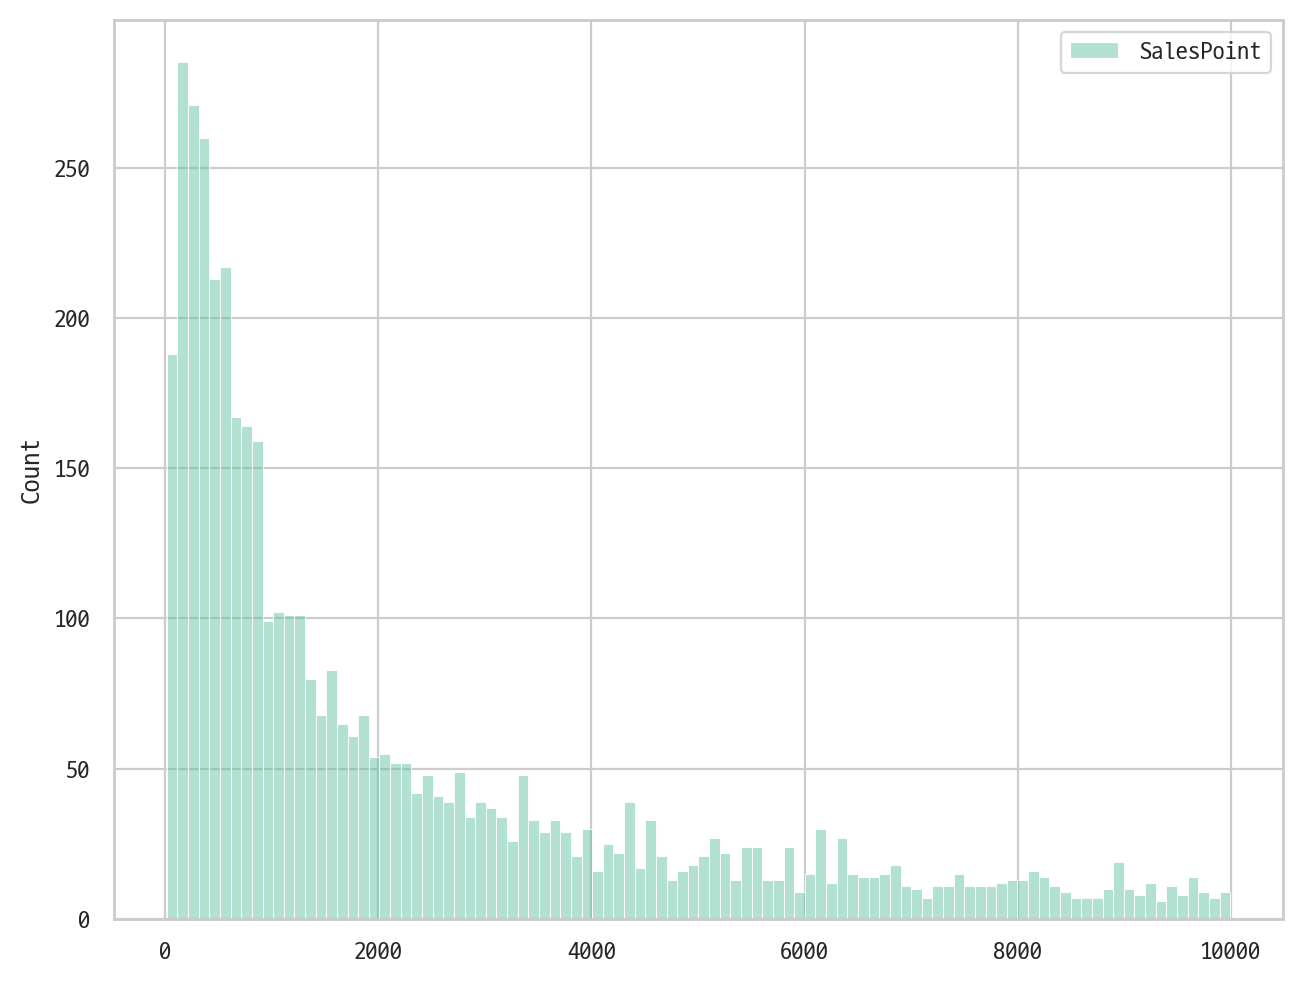

In [62]:
cond = pvtb['SalesPoint'] < 10000
temp = pvtb[cond]
sns.histplot(temp,bins=100);

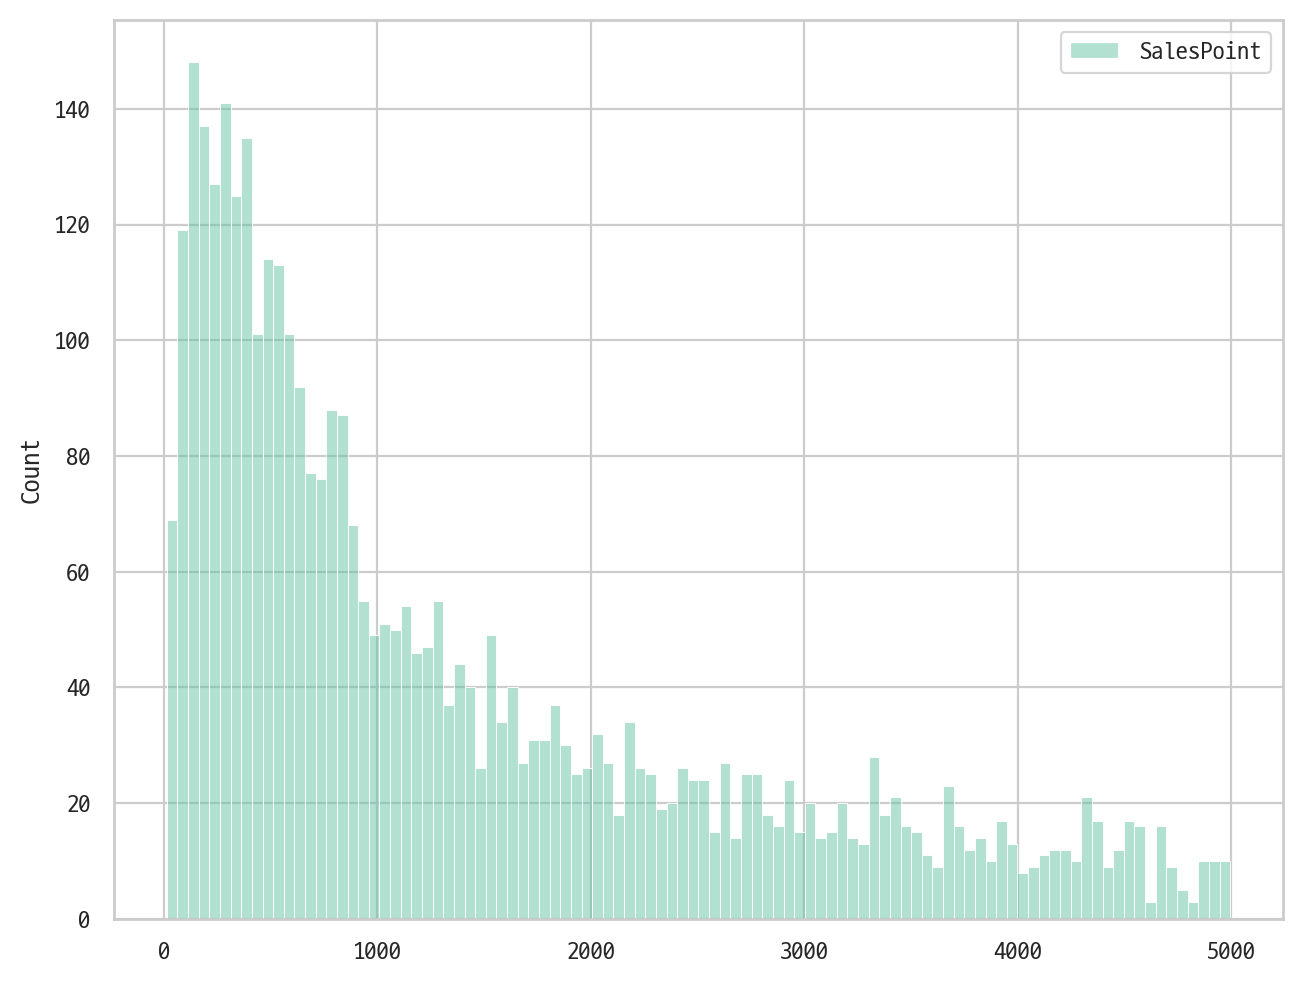

In [63]:
cond = pvtb['SalesPoint'] < 5000
temp = pvtb[cond]
sns.histplot(temp,bins=100);

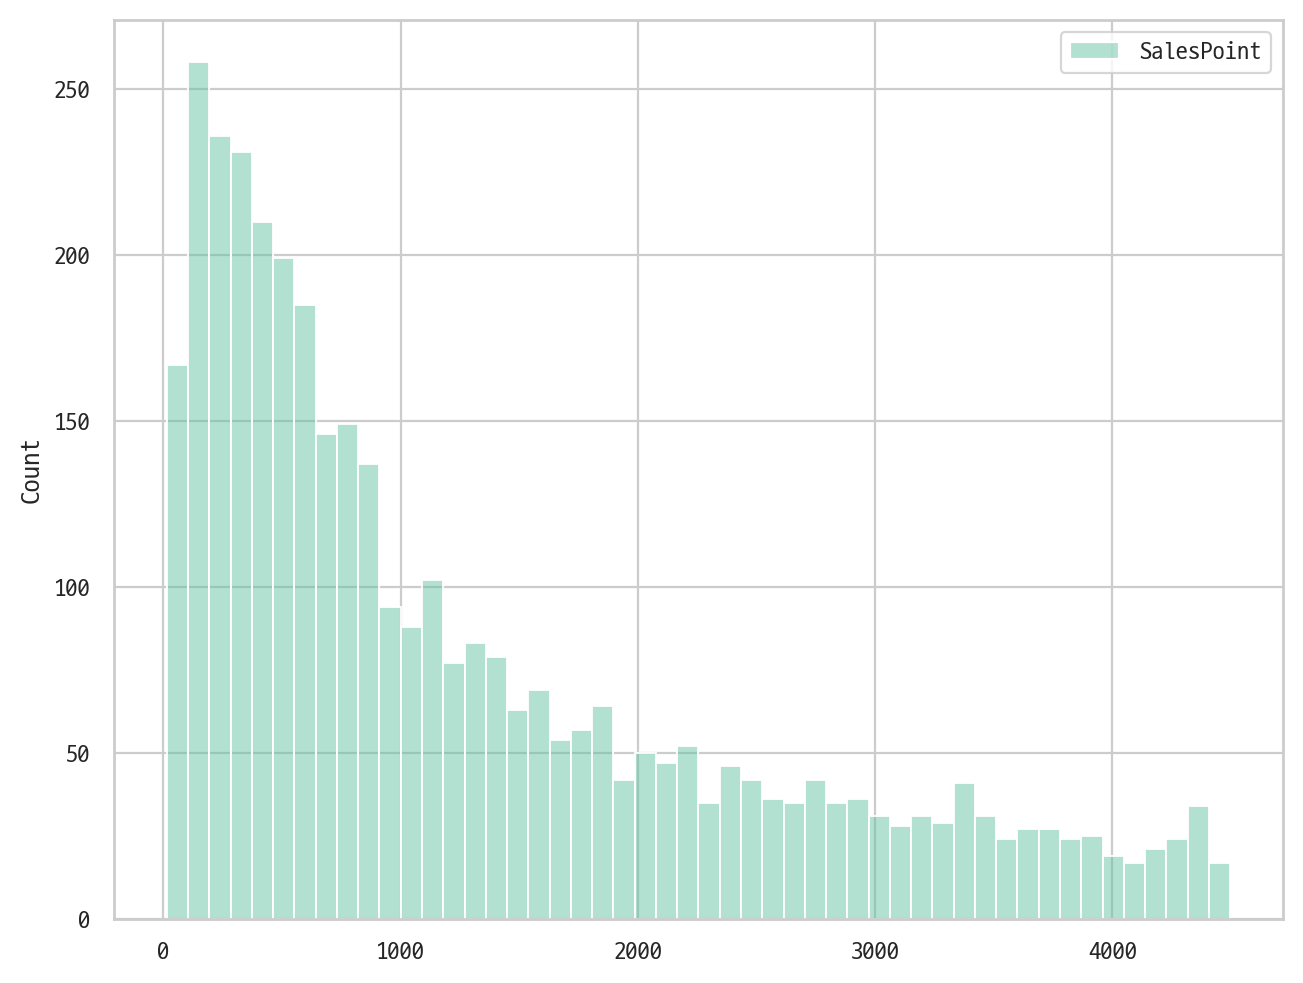

In [64]:
cond = pvtb['SalesPoint'] < 4500
temp = pvtb[cond]
sns.histplot(temp,bins=50);

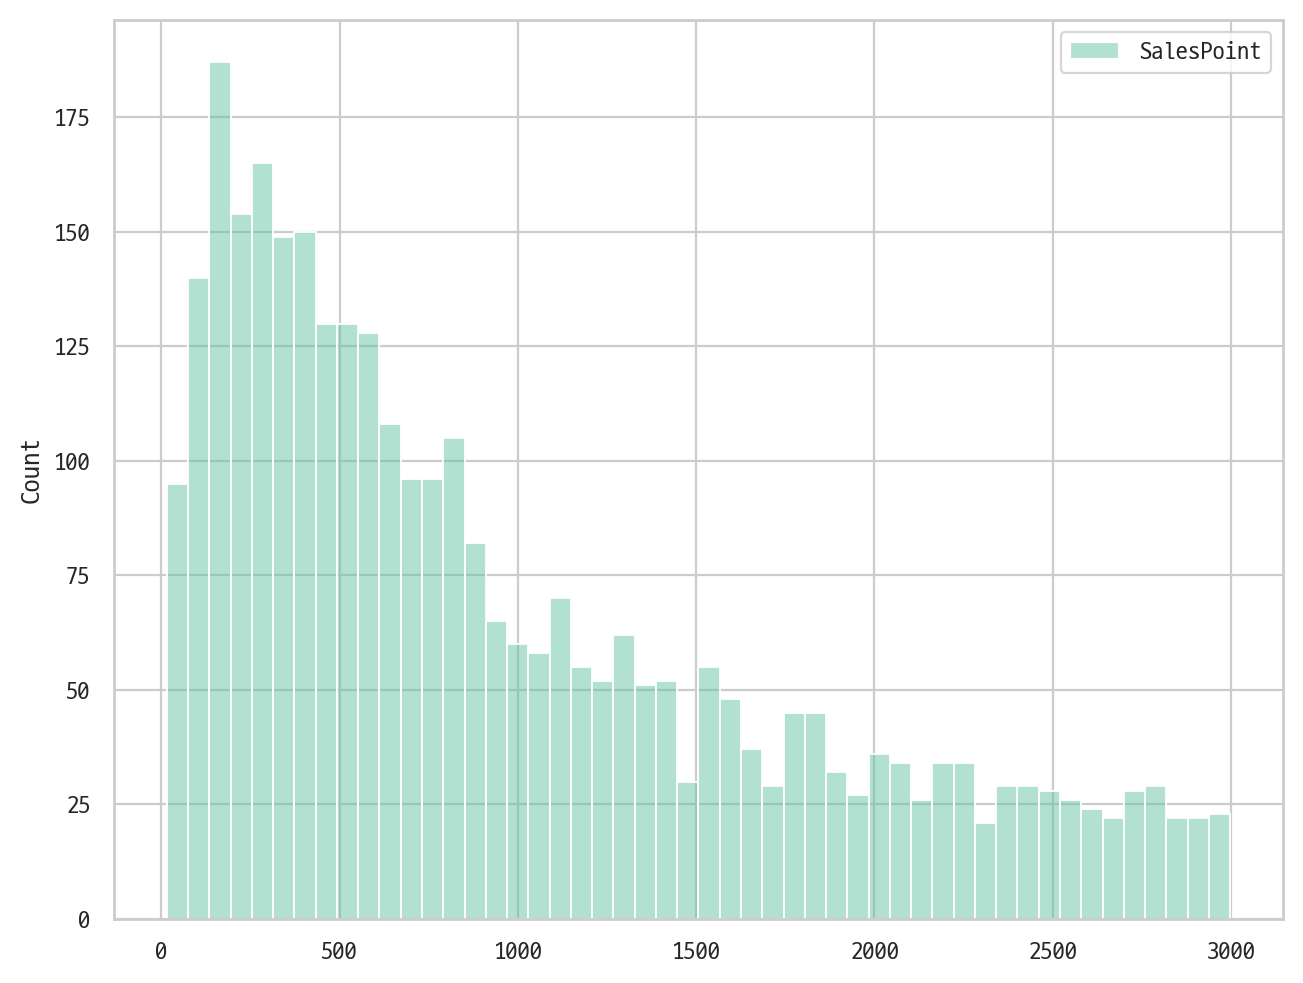

In [65]:
cond = pvtb['SalesPoint'] < 3000
temp = pvtb[cond]
sns.histplot(temp,bins=50);

In [66]:
cond = pvtb['SalesPoint'] >= 2500 
pvtb[cond]

,SalesPoint
Author,
ETS,1138125.0
David Cho,870206.0
데이빗 조 (David Cho),819133.0
유시민,743504.0
최태성,613568.0
...,...
엘리자베스 짐머만,2504.0
함윤미.문혜진,2503.0
마사 피퍼. 윌리엄 피퍼,2503.0


In [67]:
author_top_slspnt= pvtb[pvtb['SalesPoint']>=1000].index
author_top_slspnt

Index(['ETS', 'David Cho', '데이빗 조 (David Cho)', '유시민', '최태성', '세이노(SayNo)',
       '무라카미 하루키', '해커스어학연구소', '히가시노 게이고', '김호연',
       ...
       '아카시 칵카쿠', '니토리 고이치', '마이클 브린', '앤드루 스탠턴', '홍민지', 'KBS <생로병사의 비밀> 제작팀',
       '소정현', '두산동아 편집부', '죠 키이코', '원보람'],
      dtype='object', name='Author', length=3537)

In [68]:
author_top_cnt= counts[counts>=2].index
author_top_cnt

Index(['데이빗 조 (David Cho)', '길벗 R&D', '이동기', 'ETS', '해커스어학연구소', 'David Cho',
       '베르나르 베르베르', '전한길', '조정래', '최태성',
       ...
       '황종휴', '애슐리 반스', '이제니', '신현경', '도니패밀리', '강명재', '이랑', '폴 리쾨르', '미카와 고스트',
       '윤우상'],
      dtype='object', name='Author', length=1411)

In [69]:
temp = (set(author_top_cnt).difference(set(author_top_slspnt)))
display(len(temp))
display(temp)
display('김대중' in temp)

129

{'FUNA',
 'KEN',
 'SD적성검사연구소',
 'T&T교육교재개발팀',
 '강도운',
 '강영숙.박수정',
 '강효백',
 '고은정',
 '고종훈.신승욱',
 '곽동언',
 '구효서',
 '권지현',
 '김성혜',
 '김세영',
 '김송은.에듀플렉스 교육개발연구소',
 '김영준.김병태',
 '김용석',
 '김유향',
 '김지하',
 '김진구',
 '나츠미즈 리츠',
 '나카노 교코',
 '나카무라 하지메',
 '냔냐',
 '노가원',
 '니시 케이코',
 '다나카 요시키',
 '다카하시 루미코',
 '디모데 편집부',
 '레이 몽크',
 '로즈빈',
 '루스 보든',
 '류재현',
 '류향',
 '리무코로',
 '마르시아스 심',
 '마순자',
 '마에카와 유타카',
 '마이클 크라이튼',
 '메이비',
 '모리모토 슈',
 '모리하시 빙고',
 '문시현',
 '문언희',
 '발락',
 '배재민',
 '법조문연구회',
 '생명의말씀사 편집부',
 '성혜림',
 '손석춘',
 '손에스더',
 '송재정',
 '스에츠구 유키',
 '스즈키 히사시',
 '시사상식편집부',
 '시사영어사 편집부',
 '신일숙',
 '실천민속학회',
 '심우철.박진우',
 '아라키 신',
 '아오이 세키나',
 '아카마츠 켄',
 '아카필로 편집부',
 '아키야마 미즈히토',
 '안창현',
 '애덤 잭슨',
 '앨런 폴섬',
 '야마모토 아리',
 '야스다 스즈히토',
 '에듀스 인재개발원',
 '에듀윌 교육출판연구소',
 '에듀윌 상식연구소',
 '엘리자베트 루디네스코',
 '영진교재개발팀',
 '오바 츠쿠미',
 '오사카 미에코',
 '오우기 유즈하',
 '오자와 유키',
 '옥한흠',
 '윈글리쉬닷컴',
 '윌리엄 리스트 히트문',
 '유도주',
 '유미즈루 이즈루',
 '유연',
 '유우키 마사미',
 '유호철',
 '이동숙',
 '이와이 슌지',
 '이육사',
 '이자와 모토히코',
 '이정우',
 '이진욱',
 '이태종',
 '장재혁',
 '장정일',
 '잭 캔필드

False

In [70]:
temp = (set(author_top_slspnt).difference(set(author_top_cnt)))
display(len(temp))
display(temp)
display('김대중' in temp)

2255

{'안도 다다오',
 '머레이 브룸버그.멜빈 고든',
 '스콧 로젤.내털리 헬',
 '기형도',
 'Charles C. Manz',
 '김동리',
 '와카야마 요코',
 '조한경',
 '폴렛 데일',
 '김민아',
 '박진영',
 '쓰루타니 가오리',
 '서이레',
 '박지성',
 '유진 T.젠들린',
 '존 르 카레',
 '리디아 데이비스',
 '장영지',
 '정주연',
 '제프 호킨스',
 '조혜진',
 '마이클 셸런버거',
 '메리 올리버',
 '이영문',
 '토머스 프리드만',
 '수잔 벅 모스',
 '김효정.김미랑',
 '최대환',
 '이시원.시원스컨텐츠 연구소',
 '줄리언 반스',
 '아고타 크리스토프',
 '미우라 시온',
 '민석홍',
 '벨 훅스',
 '이충훈',
 '안경훈',
 '미하일 라두가',
 '조 내버로 & 마빈 칼린스',
 '테일러 스위프트',
 '마누엘 푸익',
 '신상훈',
 '유랑',
 '이수명',
 '미하엘 엔데',
 '앤터니 호로비츠',
 '에리히 프롬 지음. 방곤',
 '윤지영',
 '홍평표 외 청소년상담사 수험연구소',
 '심승현',
 '스탠리 하우워어스',
 '길다 윌리엄스',
 '백승주',
 '데이비드 보더니스',
 '편해문',
 '양민정',
 '영이',
 '다카하시 아유무',
 '게일 에반스',
 '에릭 프랭클린',
 '피트 데이비스',
 '청예',
 '니토리 고이치',
 '신애라',
 '이요셉',
 '루이스 하우즈',
 '팀 켈러.캐시 켈러',
 '권남희',
 '한나 크리츨로우',
 '캐스린 슐츠',
 'KBS한국어진흥원',
 '김기란',
 '황보태조',
 '필립 델브스 브러턴',
 '김병섭.김용세',
 '매기 넬슨',
 '이케다 미노리',
 'Lawrence J. Zwier',
 '다우치 마나부',
 '로런 벌랜트',
 '이수영',
 '한국은행',
 '마루야마 마사오+가토 슈이치',
 '김두얼',
 '김린.서현주',
 '류쉬안',
 '에릭 노먼드',
 '케이 우라나',
 '고선경',
 '윤지선.김선',
 '엘리

False

In [71]:
display('김대중' in author_top_slspnt)
display('기타 저자' in author_top_slspnt)

True

False

- ths = 1000 으로 정함
    - 기준 : 2권 올라왔지만 1000 안되는 저자들을 봤을 때 인지도 있는 저자들이 눈에 바로 들어오지 않음

In [79]:
encode_author = pd.DataFrame({'author' : author_top_slspnt.values,'val':np.arange(1,len(author_top_slspnt)+1)})
encode_author = encode_author.set_index('author')
encode_map_author=encode_author.to_dict()['val']
encode_map_author['기타 저자'] = 0

In [81]:
authors = bookinfo.Author
cond = authors.isin(author_top_slspnt)
np.sum(cond), len(bookinfo)

(7155, 9328)

In [83]:
authors[~cond] = '기타 저자'
encoded_author = authors.replace(encode_map_author)
encoded_author.info()

/tmp/ipykernel_188815/2995945027.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  authors[~cond] = '기타 저자'


<class 'pandas.core.series.Series'>
RangeIndex: 9328 entries, 0 to 9327
Series name: Author
Non-Null Count  Dtype
--------------  -----
9328 non-null   int64
dtypes: int64(1)
memory usage: 73.0 KB


### Publshr
- 이 것도 SalesPoint를 반영하면 좋겠지만,,, 일단은 지금대로 진행

In [94]:
publshrs = bookinfo.Publshr
temp = publshrs.value_counts()
temp = temp.sort_values(ascending=False)
temp

Publshr
기타 출판사               5576
대원씨아이(만화)             220
학산문화사(만화)             216
문학동네                  210
서울미디어코믹스(서울문화사)       169
민음사                   167
해커스어학연구소(Hackers)     146
창비                    145
길벗                    125
위즈덤하우스                122
김영사                   121
영진.com(영진닷컴)           96
문학과지성사                 93
열린책들                   87
21세기북스                 86
디앤씨미디어(주)(D&C미디어)      81
에스티앤북스(ST&BOOKS)       80
㈜소미미디어                 73
에스티유니타스                71
해냄                     64
웅진지식하우스                62
에듀윌                    61
랜덤하우스코리아               58
알에이치코리아(RHK)           56
영상출판미디어(주)             52
넥서스                    51
두란노                    49
한길사                    47
서울문화사                  46
한겨레출판                  46
은행나무                   45
황금가지                   45
현대지능개발사                44
까치                     43
다산북스                   42
메가스터디교육(공무원)           42
비즈니스북스                 39
쌤앤파커스                  39
와이비엠

In [95]:
encode_publshr = pd.DataFrame({'publshr' : temp.index,'val':np.arange(len(temp))})
encode_publshr = encode_publshr.set_index('publshr')
encode_map_publshr=encode_publshr.to_dict()['val']
encode_map_publshr

{'기타 출판사': 0,
 '대원씨아이(만화)': 1,
 '학산문화사(만화)': 2,
 '문학동네': 3,
 '서울미디어코믹스(서울문화사)': 4,
 '민음사': 5,
 '해커스어학연구소(Hackers)': 6,
 '창비': 7,
 '길벗': 8,
 '위즈덤하우스': 9,
 '김영사': 10,
 '영진.com(영진닷컴)': 11,
 '문학과지성사': 12,
 '열린책들': 13,
 '21세기북스': 14,
 '디앤씨미디어(주)(D&C미디어)': 15,
 '에스티앤북스(ST&BOOKS)': 16,
 '㈜소미미디어': 17,
 '에스티유니타스': 18,
 '해냄': 19,
 '웅진지식하우스': 20,
 '에듀윌': 21,
 '랜덤하우스코리아': 22,
 '알에이치코리아(RHK)': 23,
 '영상출판미디어(주)': 24,
 '넥서스': 25,
 '두란노': 26,
 '한길사': 27,
 '서울문화사': 28,
 '한겨레출판': 29,
 '은행나무': 30,
 '황금가지': 31,
 '현대지능개발사': 32,
 '까치': 33,
 '다산북스': 34,
 '메가스터디교육(공무원)': 35,
 '비즈니스북스': 36,
 '쌤앤파커스': 37,
 '와이비엠': 38,
 '사계절': 39,
 '윌북': 40,
 '시공사': 41,
 '바다출판사': 42,
 '한국경제신문': 43,
 '대원씨아이(단행본)': 44,
 '현대문학': 45,
 '시대고시기획': 46,
 '휴머니스트': 47,
 '돌베개': 48,
 '솔출판사': 49,
 '길벗이지톡': 50,
 '예담': 51,
 '해커스공무원': 52}

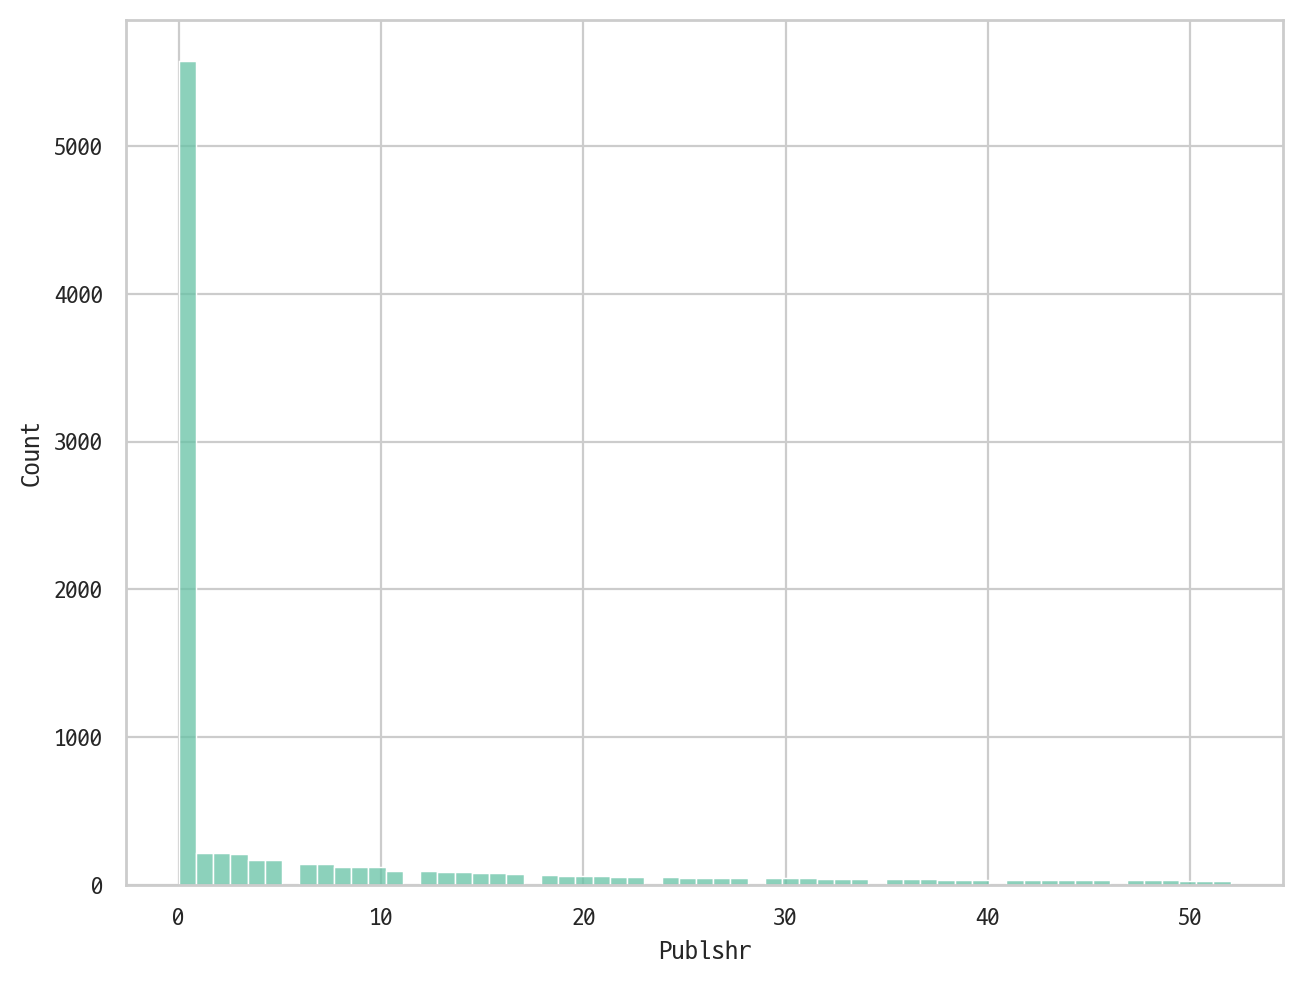

In [97]:
encoded_publshr = publshrs.replace(encode_map_publshr)
sns.histplot(encoded_publshr);

## encoding 결과 반영

In [136]:
bookinfo.columns

Index(['Rank', 'BName', 'BName_sub', 'ItemId', 'Author', 'Author_mul',
       'Publshr', 'Pdate', 'RglPrice', 'SlsPrice', 'SalesPoint', 'Category',
       'Sorce'],
      dtype='object')

- 차후 이자?를 반영한 rank를 사용할 경우, source와 rank를 사용할 수도 있음
- prototype에서는 사용하지 않는 것으로

In [85]:
cols = ['BName', 'BName_sub', 'ItemId', 'Author', 'Author_mul',
       'Publshr', 'Pdate', 'RglPrice', 'SlsPrice', 'SalesPoint', 'Category'] 
rslt = bookinfo.copy()[cols]
rslt

,BName,BName_sub,ItemId,Author,Author_mul,Publshr,Pdate,RglPrice,SlsPrice,SalesPoint,Category
0,민병철 생활영어 1,NaN,54947,기타 저자,False,기타 출판사,1979-10-01,5500,4950,177.0,외국어
1,행복에의 초대,NaN,168173,IVP(한국기독학생회출판부) 편집부,False,기타 출판사,1979-12-01,2800,2660,1960.0,종교/역학
2,훈련으로 되는 제자,NaN,458277,기타 저자,False,기타 출판사,1980-12-01,4500,4050,552.0,종교/역학
3,전태일 평전,NaN,128759,조영래,False,돌베개,1983-06-01,6000,6000,409.0,사회과학
4,제자의 삶,NaN,131488,프랜시스 M.코스그로브,False,기타 출판사,1984-07-01,12000,12000,1110.0,종교/역학
...,...,...,...,...,...,...,...,...,...,...,...
9323,장송의 프리렌 12,NaN,342597187,야마다 카네히토,True,학산문화사(만화),2024-07-25,6000,5400,10530.0,만화
9324,약사의 혼잣말 13,NaN,342597589,네코쿠라게,True,학산문화사(만화),2024-07-25,6000,5400,5870.0,만화
9325,타몬 군 지금 어느 쪽?! 7,NaN,342597714,시와스 유키,True,학산문화사(만화),2024-07-25,6000,5400,6370.0,만화
9326,천재 의사 시건방 1,NaN,342388828,강효미,True,기타 출판사,2024-07-31,13000,11700,8190.0,어린이


In [100]:
rslt['BName'] = list(encoded_bookname)
rslt['BName_sub'] = list(encoded_subname)
rslt['Publshr'] = encoded_publshr
rslt['Author'] = encoded_author
rslt['Category'] = list(encoded_category)

In [118]:
rslt['Pdate']= pd.to_datetime(bookinfo.Pdate,format='%Y-%m-%d')


In [119]:
rslt

,BName,BName_sub,ItemId,Author,Author_mul,Publshr,Pdate,RglPrice,SlsPrice,SalesPoint,Category
0,"[8075, 353, 61, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",54947,0,False,0,1979-10-01,5500,4950,177.0,"[20, 0, 0, 0, 0]"
1,"[219, 40, 2, 1847, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",168173,1727,False,0,1979-12-01,2800,2660,1960.0,"[43, 1, 44, 0, 0]"
2,"[925, 79, 124, 6, 1081, 0, 0, 0, 0, 0, 0, 0, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",458277,0,False,0,1980-12-01,4500,4050,552.0,"[43, 1, 44, 0, 0]"
3,"[3061, 726, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",128759,1467,False,48,1983-06-01,6000,6000,409.0,"[32, 22, 0, 0, 0]"
4,"[1081, 2, 214, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",131488,3427,False,0,1984-07-01,12000,12000,1110.0,"[43, 1, 44, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...
9323,"[4284, 2, 3488, 3814, 198, 0, 0, 0, 0, 0, 0, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",342597187,1038,True,2,2024-07-25,6000,5400,10530.0,"[7, 0, 0, 0, 0]"
9324,"[1806, 2, 1937, 327, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",342597589,1579,True,2,2024-07-25,6000,5400,5870.0,"[7, 0, 0, 0, 0]"
9325,"[1147, 2270, 406, 399, 770, 5268, 115, 67, 80,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",342597714,1488,True,2,2024-07-25,6000,5400,6370.0,"[7, 0, 0, 0, 0]"
9326,"[496, 2, 148, 3, 6700, 12, 0, 0, 0, 0, 0, 0, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",342388828,468,True,0,2024-07-31,13000,11700,8190.0,"[133, 0, 0, 0, 0]"


In [120]:
rslt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9328 entries, 0 to 9327
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   BName       9328 non-null   object        
 1   BName_sub   9328 non-null   object        
 2   ItemId      9328 non-null   int64         
 3   Author      9328 non-null   int64         
 4   Author_mul  9328 non-null   bool          
 5   Publshr     9328 non-null   int64         
 6   Pdate       9328 non-null   datetime64[ns]
 7   RglPrice    9328 non-null   int64         
 8   SlsPrice    9328 non-null   int64         
 9   SalesPoint  9328 non-null   float64       
 10  Category    9328 non-null   object        
dtypes: bool(1), datetime64[ns](1), float64(1), int64(5), object(3)
memory usage: 738.0+ KB


In [103]:
file_name = 'encoded_bookinfo_ver{}.csv'.format(0.75)
save_path = os.path.join(PRJCT_PATH,save_dir,file_name)
rslt.to_csv(save_path,index=False)

In [108]:
encoded = pd.read_csv(save_path)
type(encoded.BName.iloc[0])

str

- list에 담겨있는 결과물을 저장하면 str로 읽히기 때문에 번거로움
- BName, BName_sub, Category는 pkl로 저장

In [121]:
file_name = 'encoded_bookinfo_ver{}.pkl'.format(0.75)
save_path = os.path.join(PRJCT_PATH,save_dir,file_name)
rslt.to_pickle(save_path)

In [122]:
cols_df = ['ItemId', 'Author', 'Author_mul',
       'Publshr', 'Pdate', 'RglPrice', 'SlsPrice', 'SalesPoint']
cols_pkl = ['BName', 'BName_sub','Category']

In [123]:
import pickle

with open(save_path,'rb') as f:
    data = pickle.load(f)
    
data

,BName,BName_sub,ItemId,Author,Author_mul,Publshr,Pdate,RglPrice,SlsPrice,SalesPoint,Category
0,"[8075, 353, 61, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",54947,0,False,0,1979-10-01,5500,4950,177.0,"[20, 0, 0, 0, 0]"
1,"[219, 40, 2, 1847, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",168173,1727,False,0,1979-12-01,2800,2660,1960.0,"[43, 1, 44, 0, 0]"
2,"[925, 79, 124, 6, 1081, 0, 0, 0, 0, 0, 0, 0, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",458277,0,False,0,1980-12-01,4500,4050,552.0,"[43, 1, 44, 0, 0]"
3,"[3061, 726, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",128759,1467,False,48,1983-06-01,6000,6000,409.0,"[32, 22, 0, 0, 0]"
4,"[1081, 2, 214, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",131488,3427,False,0,1984-07-01,12000,12000,1110.0,"[43, 1, 44, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...
9323,"[4284, 2, 3488, 3814, 198, 0, 0, 0, 0, 0, 0, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",342597187,1038,True,2,2024-07-25,6000,5400,10530.0,"[7, 0, 0, 0, 0]"
9324,"[1806, 2, 1937, 327, 0, 0, 0, 0, 0, 0, 0, 0, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",342597589,1579,True,2,2024-07-25,6000,5400,5870.0,"[7, 0, 0, 0, 0]"
9325,"[1147, 2270, 406, 399, 770, 5268, 115, 67, 80,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",342597714,1488,True,2,2024-07-25,6000,5400,6370.0,"[7, 0, 0, 0, 0]"
9326,"[496, 2, 148, 3, 6700, 12, 0, 0, 0, 0, 0, 0, 0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",342388828,468,True,0,2024-07-31,13000,11700,8190.0,"[133, 0, 0, 0, 0]"


In [124]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9328 entries, 0 to 9327
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   BName       9328 non-null   object        
 1   BName_sub   9328 non-null   object        
 2   ItemId      9328 non-null   int64         
 3   Author      9328 non-null   int64         
 4   Author_mul  9328 non-null   bool          
 5   Publshr     9328 non-null   int64         
 6   Pdate       9328 non-null   datetime64[ns]
 7   RglPrice    9328 non-null   int64         
 8   SlsPrice    9328 non-null   int64         
 9   SalesPoint  9328 non-null   float64       
 10  Category    9328 non-null   object        
dtypes: bool(1), datetime64[ns](1), float64(1), int64(5), object(3)
memory usage: 738.0+ KB
